In [1]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec

plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
warnings.filterwarnings("ignore")

df = pd.read_csv('DomesticAirlines_OnTimePerformance_data.csv', error_bad_lines=False)

In [2]:
#-------------------------------------------------------------------------------------------------------------------
# Data Cleaning
#-------------------------------------------------------------------------------------------------------------------
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(df.shape[0]-missing_df['missing values'])/df.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,Route,0,100.0
1,Departing_Port,0,100.0
2,Arriving_Port,0,100.0
3,Airline,0,100.0
4,Sectors_Scheduled,0,100.0
5,Sectors_Flown,0,100.0
6,Cancellations,0,100.0
7,Departures_On_Time,0,100.0
8,Arrivals_On_Time,0,100.0
9,Departures_Delayed,0,100.0


In [32]:
#-------------------------------------------------------------------------------------------------------------------
# Remove Summarized Columns for "ALL AIRPORTS"
#-------------------------------------------------------------------------------------------------------------------
df = df[~df['Airline'].isin(['All Airlines'])]
df = df[~df['Departing_Port'].isin(['All Ports'])]

#-------------------------------------------------------------------------------------------------------------------
# function that extract statistical parameters from a grouby objet:
#-------------------------------------------------------------------------------------------------------------------
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.sum(), 'mean': group.mean()}

#-------------------------------------------------------------------------------------------------------------------
# Creation of a dataframe with statitical infos on each airline (Sectors Flown ):
#-------------------------------------------------------------------------------------------------------------------
global_stats = df['Sectors_Flown'].groupby(df['Airline']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')

#-------------------------------------------------------------------------------------------------------------------
# Creation of a dataframe with statitical infos on each airline (Arrival Delays ):
#-------------------------------------------------------------------------------------------------------------------
global_stats_del = df['Departures_Delayed'].groupby(df['Airline']).apply(get_stats).unstack()
global_stats_del = global_stats.sort_values('count')

#-------------------------------------------------------------------------------------------------------------------
# Code for Airlines (IATA)
#-------------------------------------------------------------------------------------------------------------------
airlines_names = pd.read_csv('iata.csv')
abbr_companies = airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()


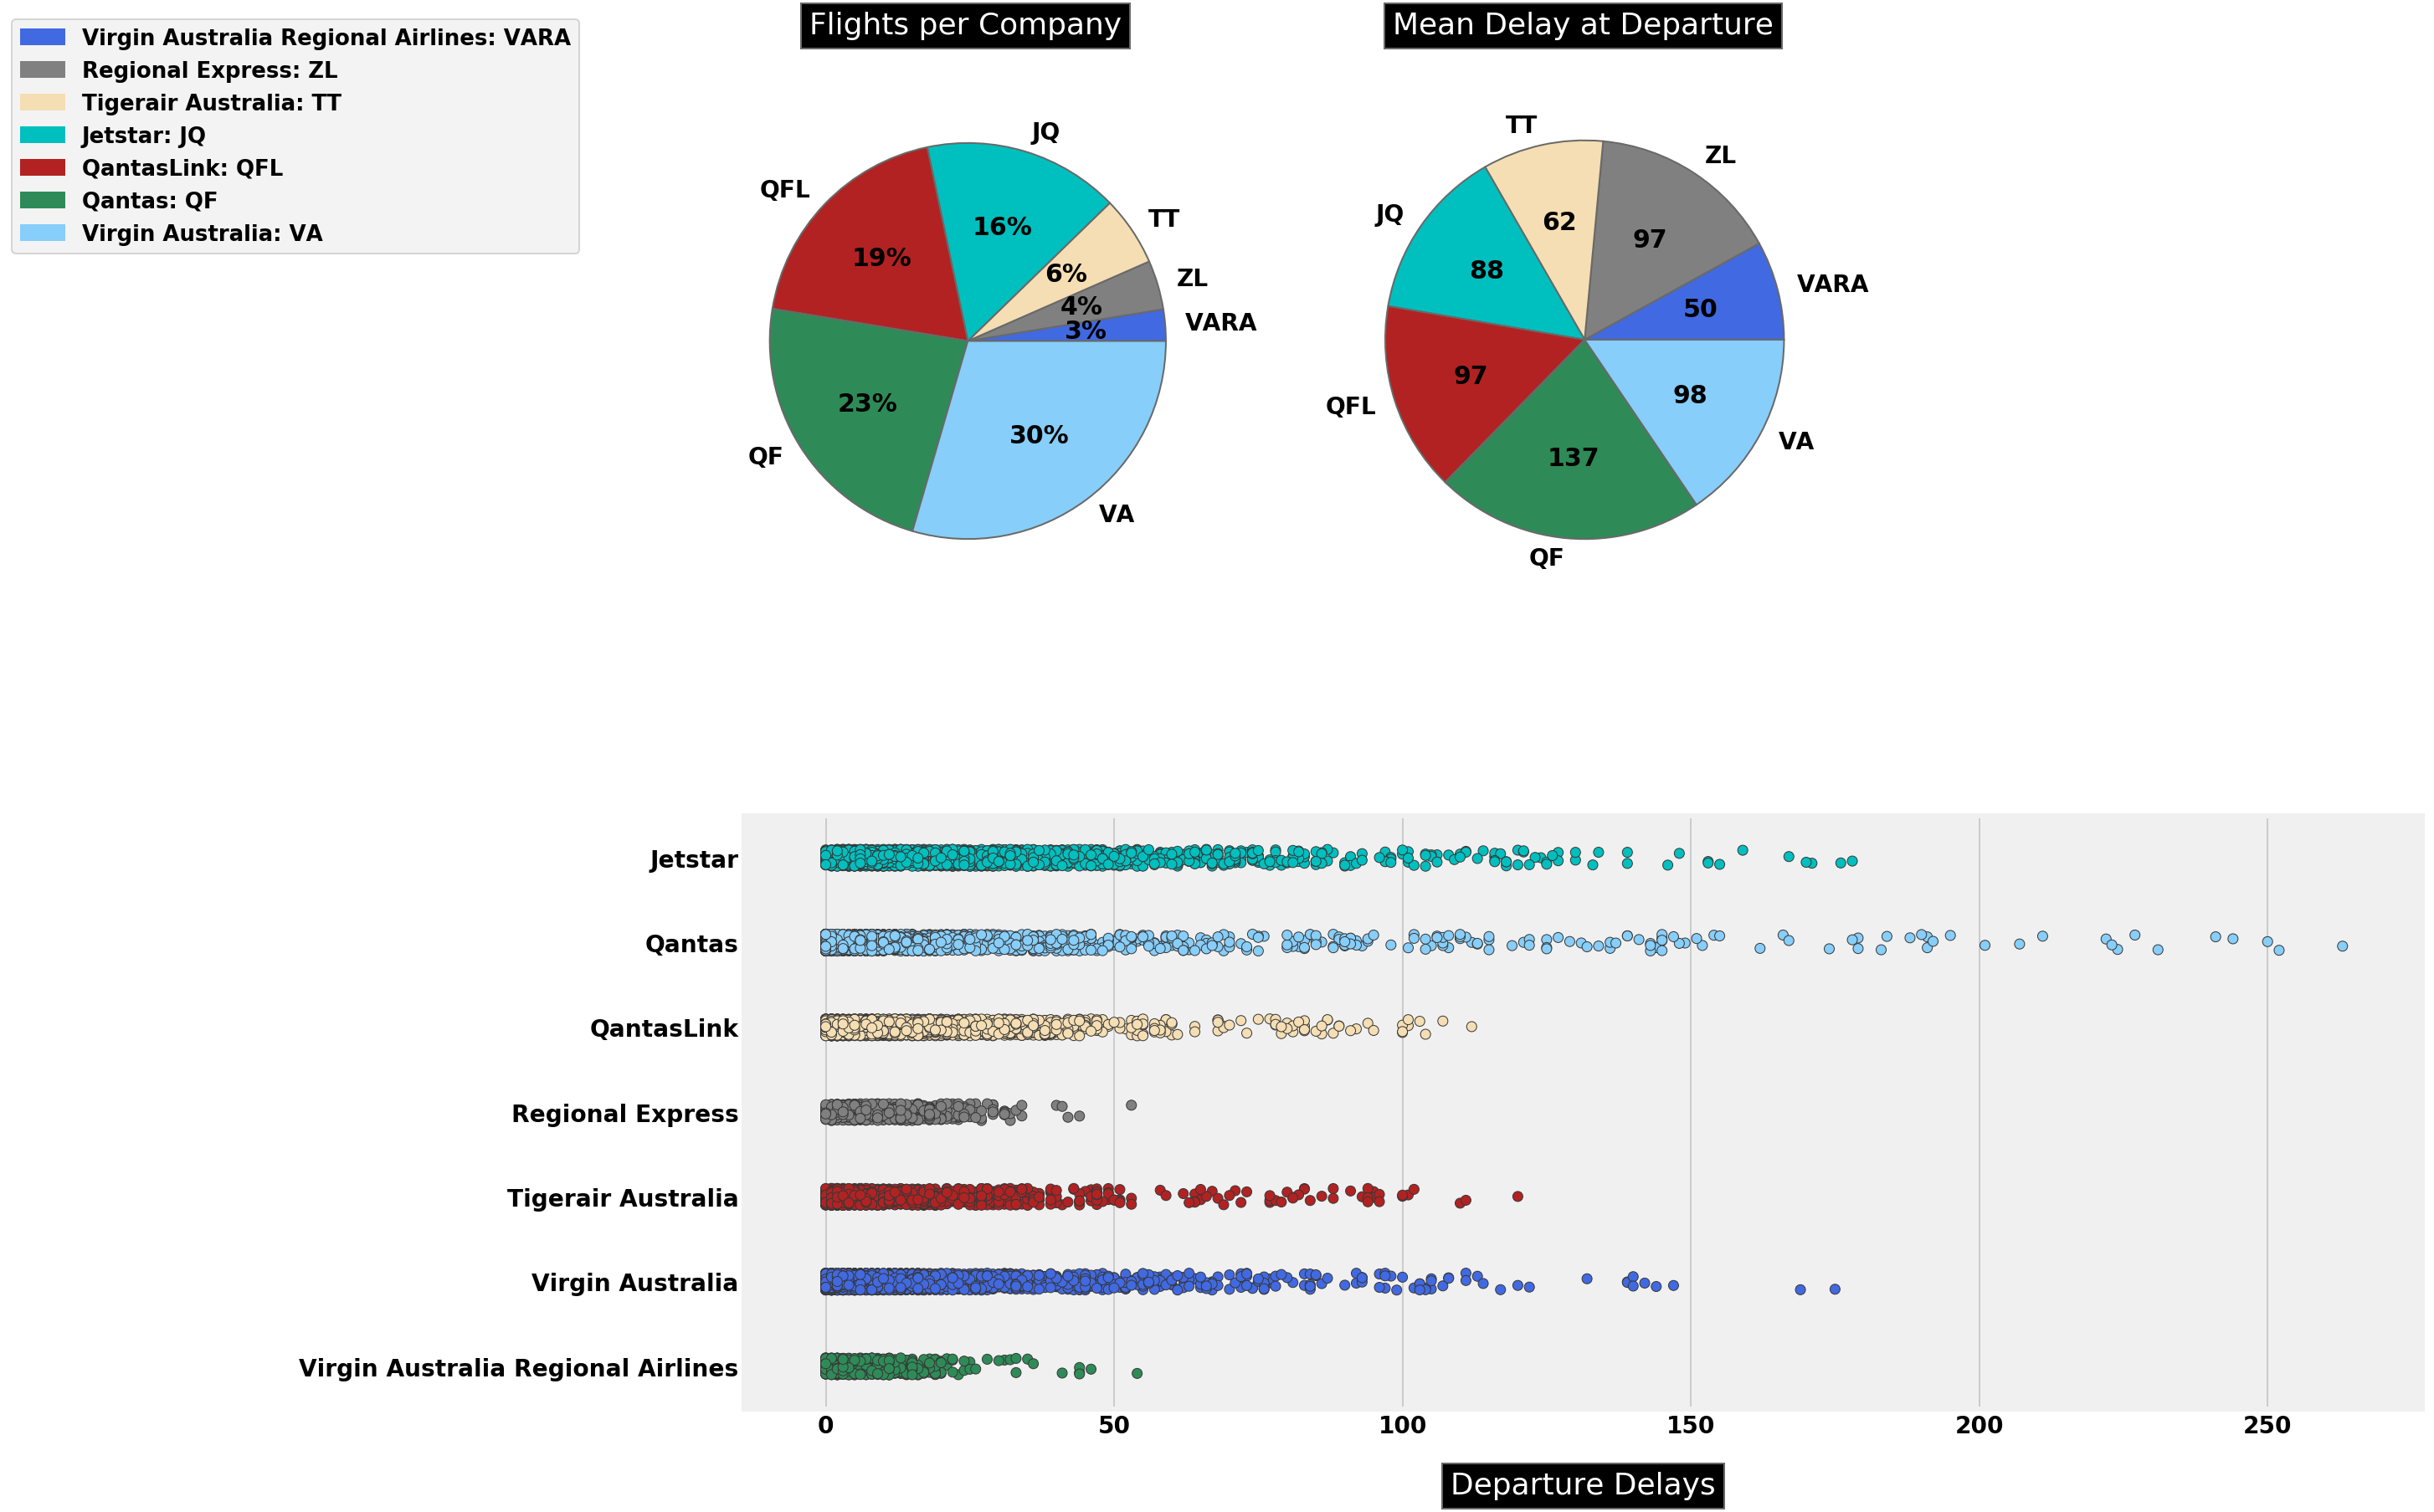

In [4]:
font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 15}
mpl.rc('font', **font)

import matplotlib.patches as mpatches

df2 = df.loc[:, ['Airline', 'Departures_Delayed']]
df2['Airline'] = df2['Airline'].replace(abbr_companies)
col = ['VARA','ZL','TT','JQ','QFL','QF','VA']
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue']

fig = plt.figure(1, figsize=(16,15))
gs= plt.GridSpec(2, 3, wspace=0.4, hspace=0.3)             
ax1=fig.add_subplot(gs[0,0]) 
ax2=fig.add_subplot(gs[0,1]) 
ax3=fig.add_subplot(gs[1,:])

#-------------------------------------------------------------------------------------------------------------------
# Pie Chart 1: Flights For Each Company
#-------------------------------------------------------------------------------------------------------------------

labels = [s for s in  global_stats.index]
sizes  = global_stats['count'].values
patches, texts, autotexts = ax1.pie(sizes, explode = None,
                                labels=col, colors = colors,  autopct='%1.0f%%',
                                shadow=False, startangle=0)

for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax1.axis('equal')
ax1.set_title('Flights per Company', bbox={'facecolor':'black', 'pad':5},
              color = 'w',fontsize=18)


# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(len(abbr_companies)):
    comp_handler.append(mpatches.Patch(color=colors[i],
            label = global_stats.index[i] + ': ' + abbr_companies[global_stats.index[i]]))
ax1.legend(handles=comp_handler, bbox_to_anchor=(0, 0.9), 
           fontsize = 13, bbox_transform=plt.gcf().transFigure)

#-------------------------------------------------------------------------------------------------------------------
# Pie chart 2: Mean Delay at Departure
#-------------------------------------------------------------------------------------------------------------------
sizes  = global_stats_del['mean'].values
sizes  = [max(s,0) for s in sizes]
patches, texts, autotexts = ax2.pie(sizes, explode = None, labels = col,
                                colors = colors, shadow=False, startangle=0,
                                autopct = lambda p :  '{:.0f}'.format(p * sum(sizes) / 100))
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax2.axis('equal')
ax2.set_title('Mean Delay at Departure', bbox={'facecolor':'black', 'pad':5}, color='w', fontsize=18)

#--------------------------------------------------------------------------------------------------------------------
# Striplot With All the Values Reported for the Delays
##-------------------------------------------------------------------------------------------------------------------

colors = ['c', 'lightskyblue', 'wheat', 'grey', 'firebrick','royalblue','seagreen']

ax3 = sns.stripplot(y="Airline", x="Departures_Delayed", size = 6, palette = colors,
                    data=df, linewidth = 0.5,  jitter=True)

plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)

plt.xlabel('Departure Delays', fontsize=18, bbox={'facecolor':'black', 'pad':5},color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)



KeyError: 'Jetstar'

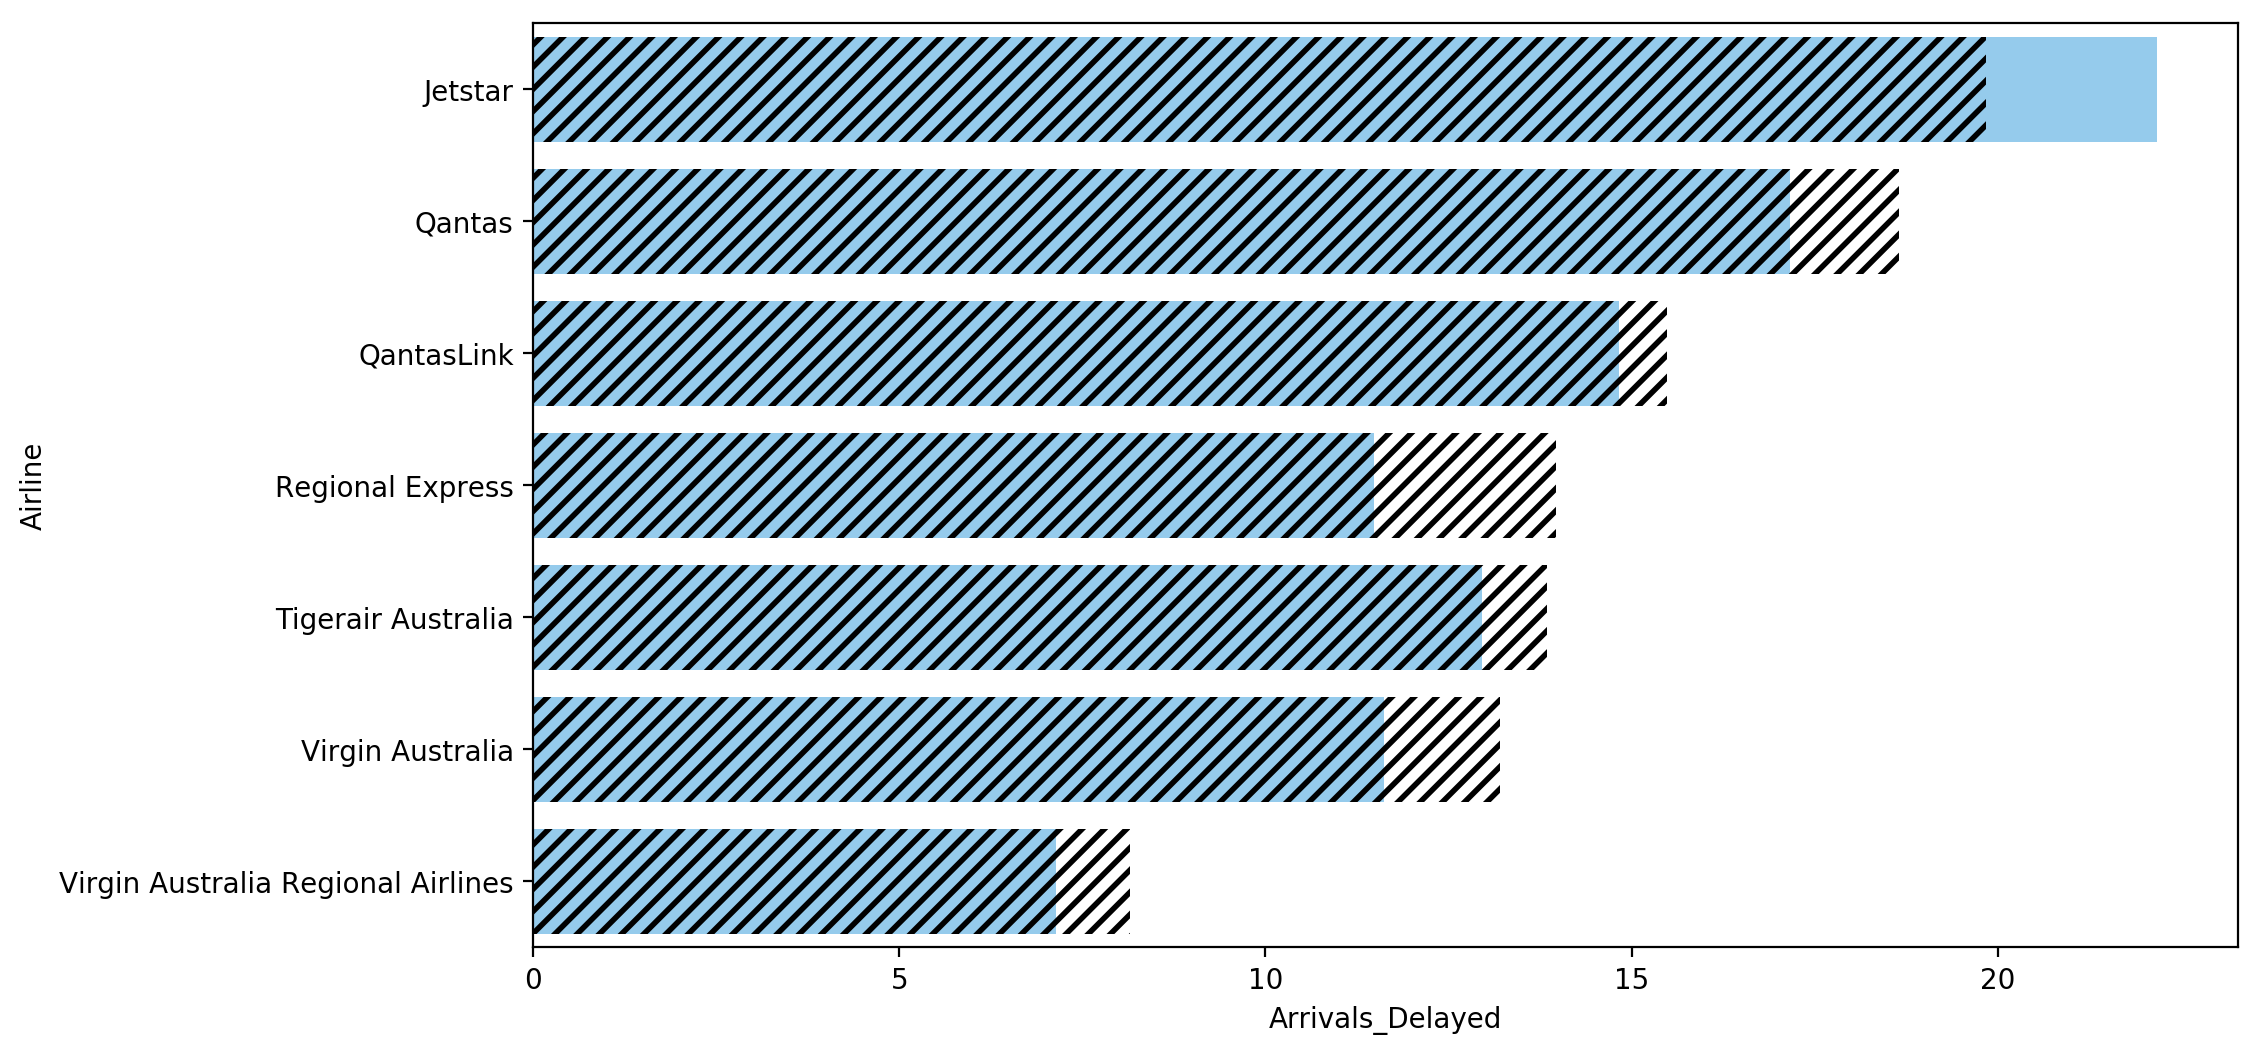

In [5]:
#-------------------------------------------------------------------------------------------------------------------
# Linegraph Total Delays / Arrivals 
#-------------------------------------------------------------------------------------------------------------------

abbr_companies = airlines_names.set_index('AIRLINE')['IATA_CODE'].to_dict()
abbr_companies

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['hatch.linewidth'] = 2.0  

fig = plt.figure(1, figsize=(11,6))
ax = sns.barplot(x="Departures_Delayed", y="Airline", data=df, color="lightskyblue", ci=None)
ax = sns.barplot(x="Arrivals_Delayed", y="Airline", data=df, color="r", hatch = '///',
                 alpha = 0.0, ci=None)

labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
ax.yaxis.label.set_visible(False)
plt.xlabel('Mean delay [min] (@departure: blue, @arrival: hatch lines)',fontsize=14, weight = 'bold', labelpad=10);

comp_handler = []
for i in range(len(abbr_companies)):
    comp_handler.append(mpatches.Patch(color=colors[i],
            label = global_stats.index[i] + ': ' + abbr_companies[global_stats.index[i]]))
ax1.legend(handles=comp_handler, bbox_to_anchor=(0, 0.9), 
           fontsize = 13, bbox_transform=plt.gcf().transFigure)

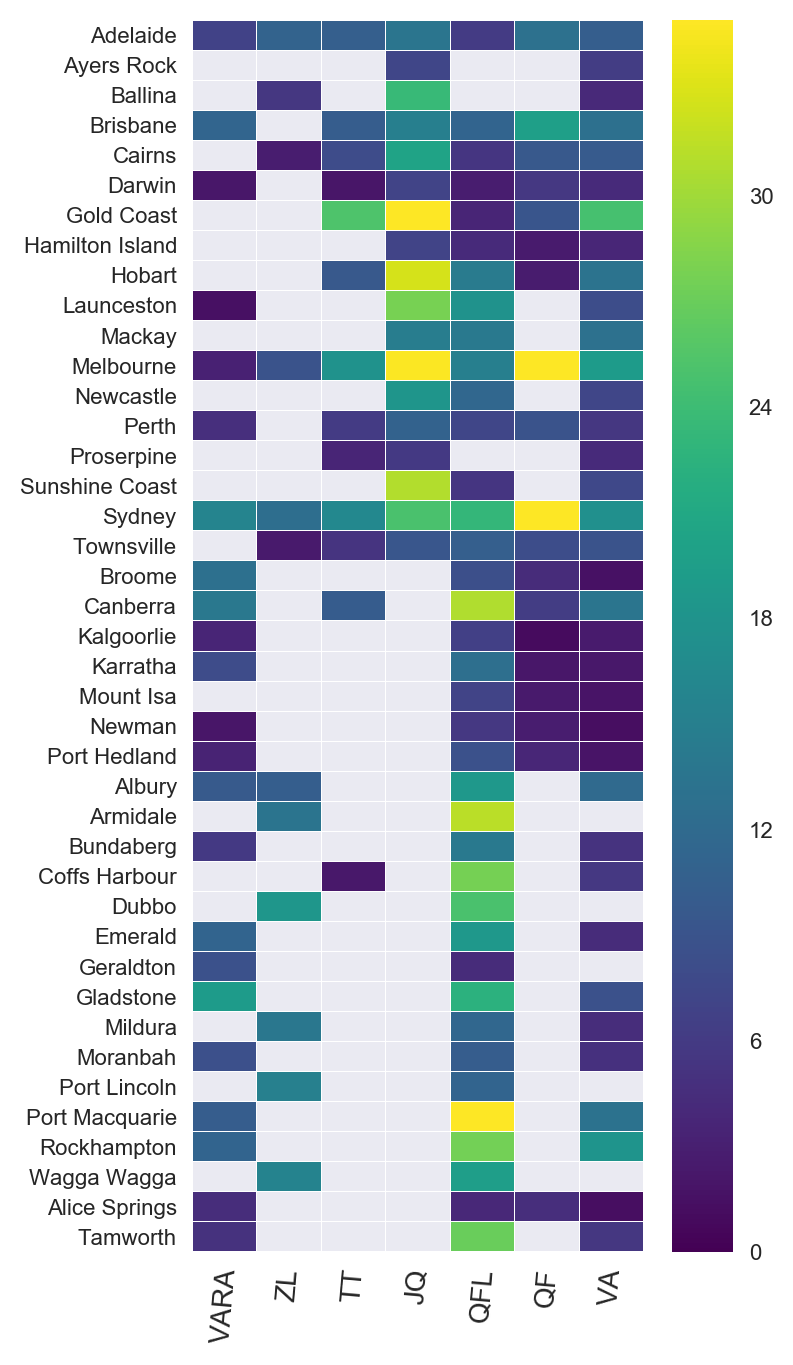

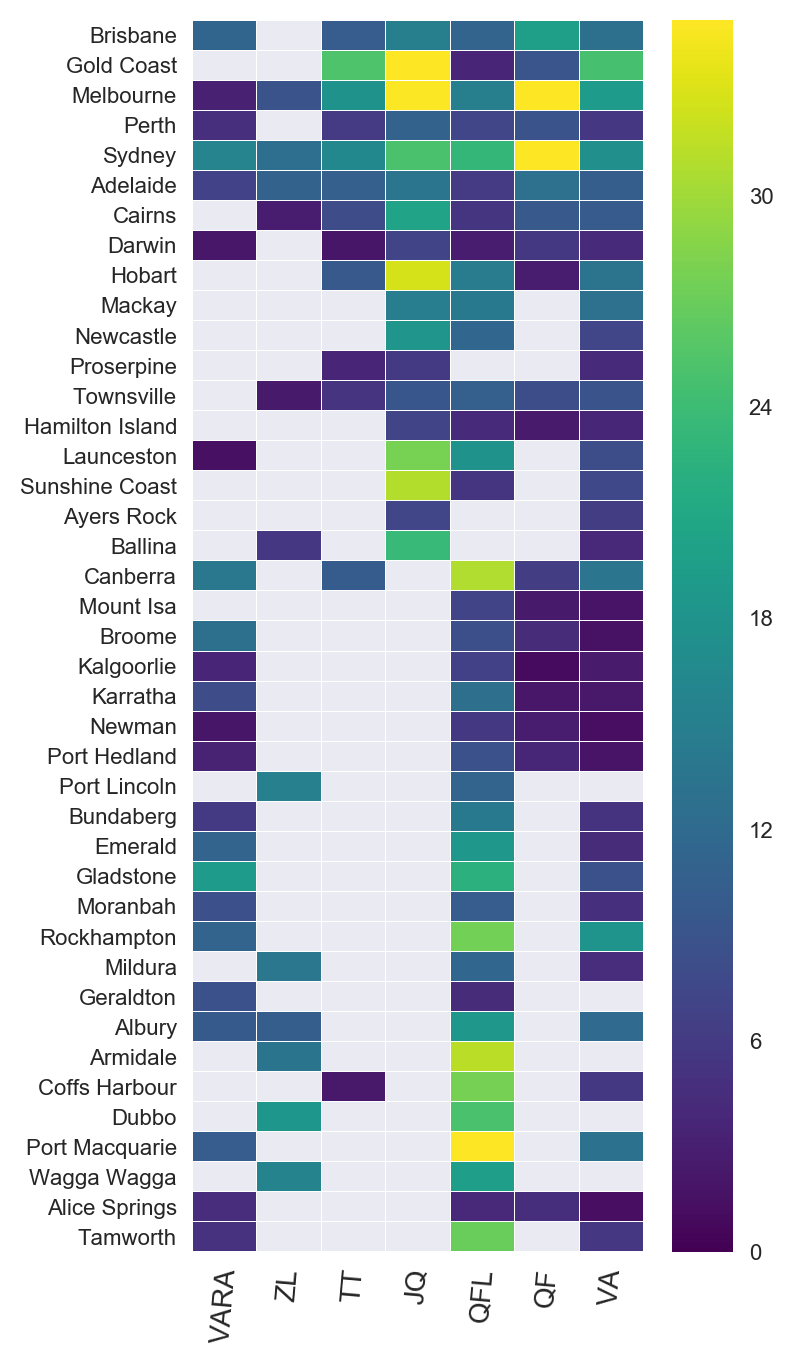

In [35]:
#-------------------------------------------------------------------------------------------------------------------
# Heatmap Departure Delays 
#-------------------------------------------------------------------------------------------------------------------
abbr_companies = airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()
airport_mean_delays = pd.DataFrame(pd.Series(df['Departing_Port'].unique()))
airport_mean_delays.set_index(0, drop = True, inplace = True)

for carrier in abbr_companies.keys():
    df1 = df[df['Airline'] == carrier]
    test = df1['Departures_Delayed'].groupby(df['Departing_Port']).apply(get_stats).unstack()
    airport_mean_delays[carrier] = test.loc[:,'mean'] 
    
sns.set(context="paper")
fig = plt.figure( figsize=(8,8))

ax = fig.add_subplot(1,2,1)
subset = airport_mean_delays.iloc[:50,:].rename(columns = abbr_companies)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="viridis", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)
#-------------------------------------------------------------------------------------------------------------------
# Heatmap Departure Arrivals  
#-------------------------------------------------------------------------------------------------------------------
airport_mean_delays = pd.DataFrame(pd.Series(df['Arriving_Port'].unique()))
airport_mean_delays.set_index(0, drop = True, inplace = True)

for carrier in abbr_companies.keys():
    df1 = df[df['Airline'] == carrier]
    test = df1['Arrivals_Delayed'].groupby(df['Arriving_Port']).apply(get_stats).unstack()
    airport_mean_delays[carrier] = test.loc[:, 'mean']
    
for carrier in abbr_companies.keys():
    df1 = df[df['Airline'] == carrier]
    test = df1['Departures_Delayed'].groupby(df['Departing_Port']).apply(get_stats).unstack()
    airport_mean_delays[carrier] = test.loc[:,'mean'] 
    
sns.set(context="paper")
fig = plt.figure( figsize=(8,8))

ax = fig.add_subplot(1,2,1)
subset = airport_mean_delays.iloc[:50,:].rename(columns = abbr_companies)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="viridis", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

In [8]:
df['Date'] = pd.to_datetime(df.Year.astype(str) + '-' + df.Month_Num.astype(str))

In [15]:
df.head(1000)

,Route,Departing_Port,Arriving_Port,Airline,Sectors_Scheduled,Sectors_Flown,Cancellations,Departures_On_Time,Arrivals_On_Time,Departures_Delayed,Arrivals_Delayed,Year,Month_Num,Date
125,Adelaide-Brisbane,Adelaide,Brisbane,Jetstar,31,31,0,30,31,1,0,2015,1,2015-01-01
126,Adelaide-Gold Coast,Adelaide,Gold Coast,Jetstar,47,46,1,42,43,4,3,2015,1,2015-01-01
127,Adelaide-Melbourne,Adelaide,Melbourne,Jetstar,122,116,6,104,102,12,14,2015,1,2015-01-01
128,Adelaide-Perth,Adelaide,Perth,Jetstar,43,43,0,38,41,5,2,2015,1,2015-01-01
129,Adelaide-Sydney,Adelaide,Sydney,Jetstar,150,146,4,118,123,28,23,2015,1,2015-01-01
131,Ayers Rock-Sydney,Ayers Rock,Sydney,Jetstar,25,25,0,24,21,1,4,2015,1,2015-01-01
132,Ballina-Sydney,Ballina,Sydney,Jetstar,90,90,0,68,71,22,19,2015,1,2015-01-01
133,Brisbane-Adelaide,Brisbane,Adelaide,Jetstar,31,31,0,31,31,0,0,2015,1,2015-01-01
134,Brisbane-Cairns,Brisbane,Cairns,Jetstar,119,117,2,97,101,20,16,2015,1,2015-01-01
135,Brisbane-Darwin,Brisbane,Darwin,Jetstar,30,30,0,20,28,10,2,2015,1,2015-01-01


In [28]:
cancelled = df.sum()['Cancellations']
scheduled = df.sum()['Sectors_Scheduled']
operated = scheduled - cancelled
ratio_oper = operated / scheduled * 100
ratio_cancel = 100 - ratio_oper

print("Scheduled flights: ", scheduled)
print("Cancelled flights: ", cancelled)
print("Operated flights: ", operated)
print("\n")
print("Ratio Operated Flights: %s" % ratio_oper)
print("Ratio Canceled Flights: %s" % ratio_cancel)

Scheduled flights:  1580976
Cancelled flights:  28357
Operated flights:  1552619


Ratio Operated Flights: 98.20636113388186
Ratio Canceled Flights: 1.793638866118144


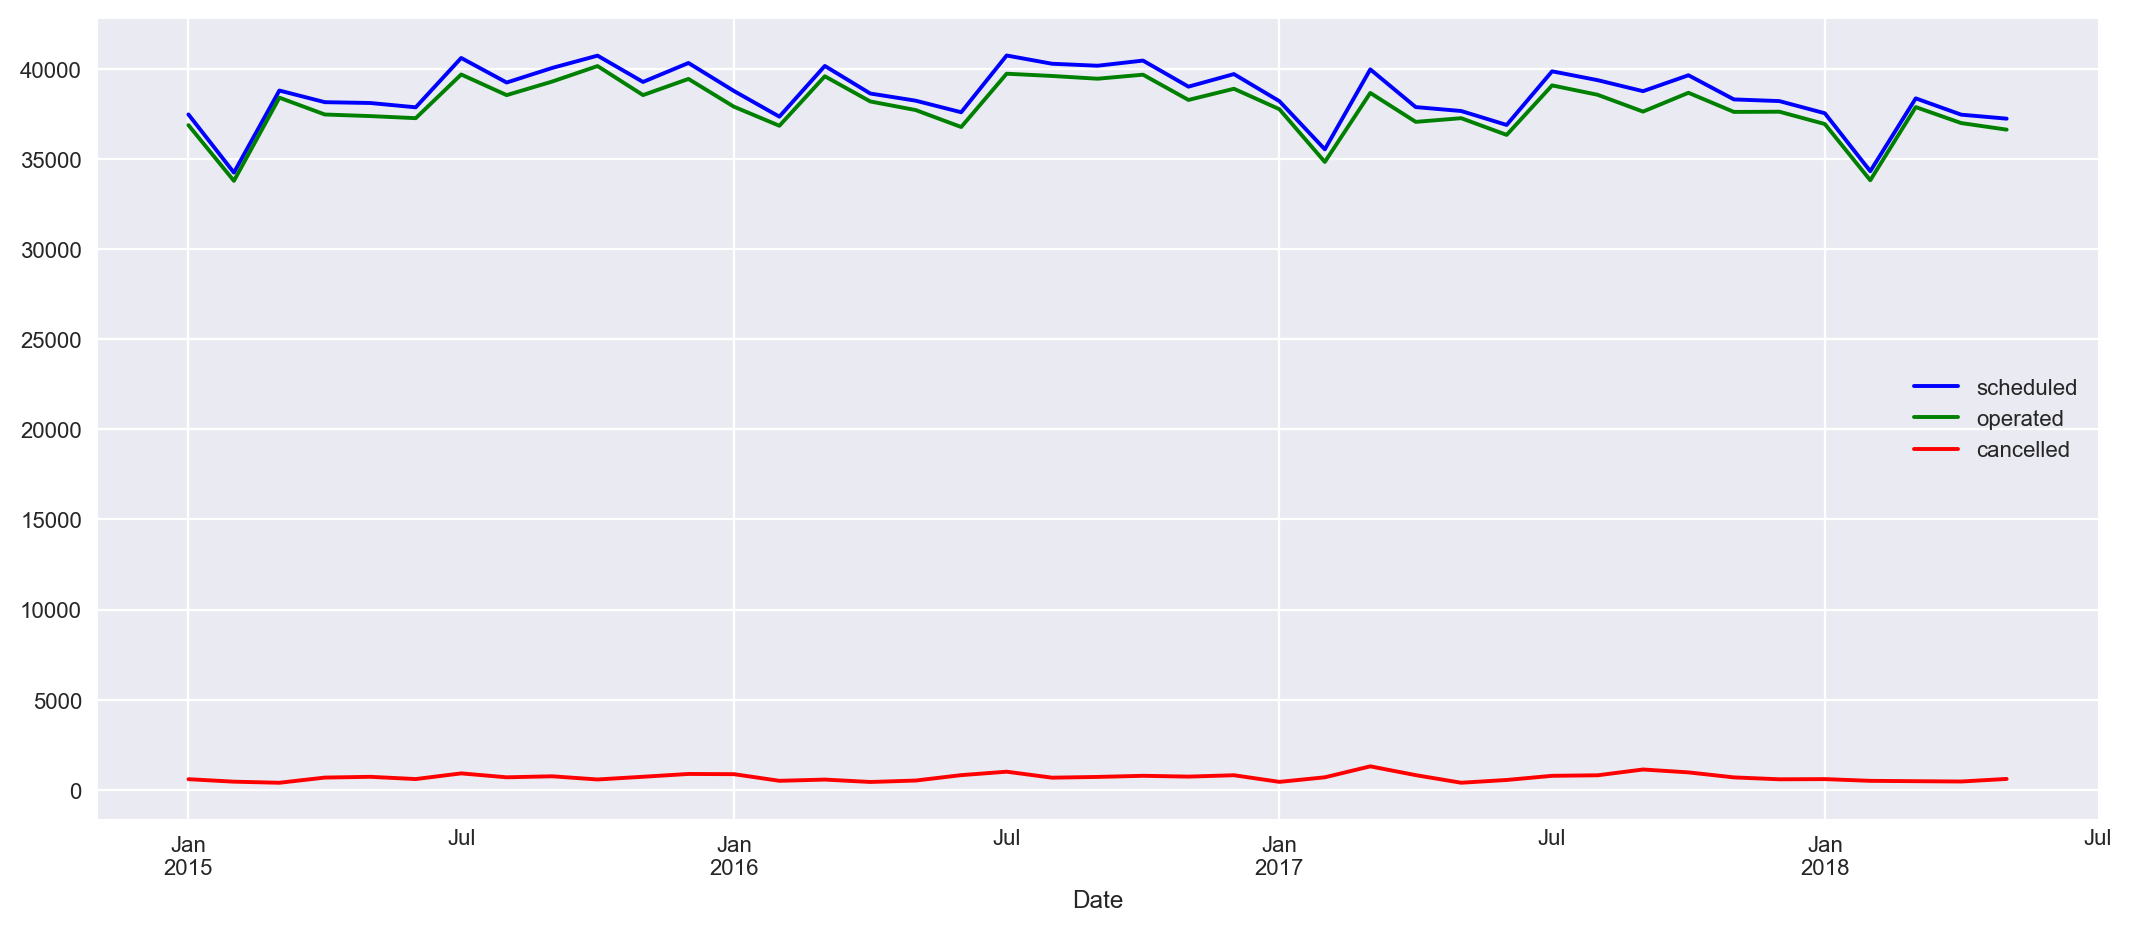

In [20]:
fig = plt.figure(figsize=(10,4));

ax = fig.add_axes([0,0,1,1]);

df.groupby('Date').sum()['Sectors_Scheduled'].plot.line(c='b', label="scheduled");
df.groupby('Date').sum()['Sectors_Flown'].plot.line(c='g', label="operated");
df.groupby('Date').sum()['Cancellations'].plot.line(c='r', label="cancelled");

ax.legend();

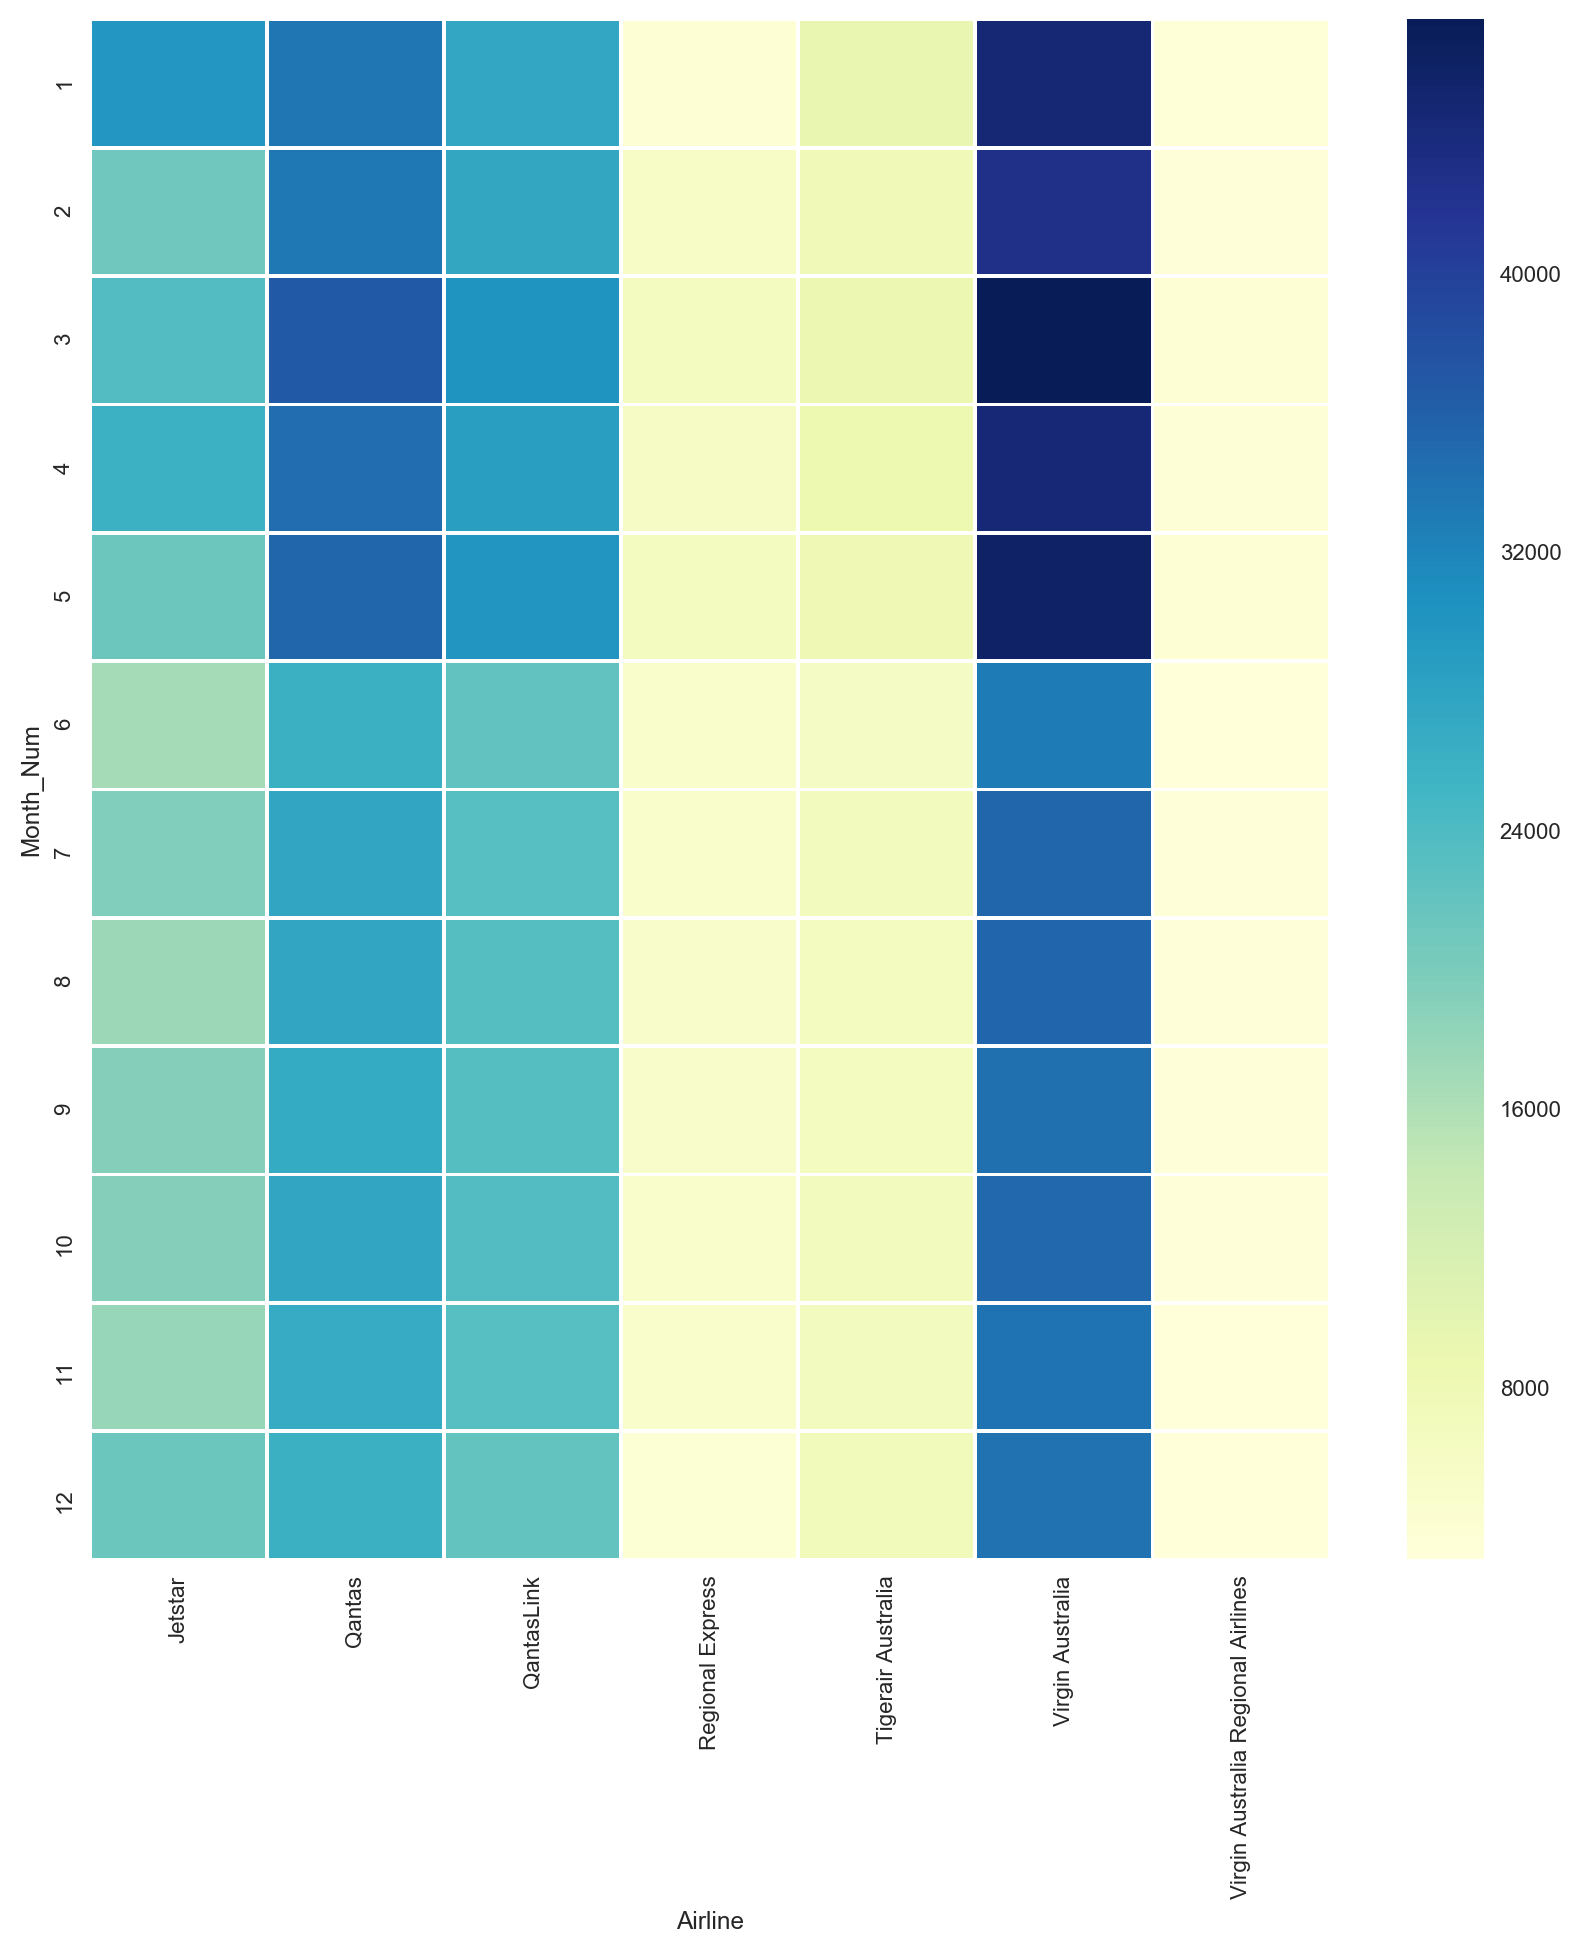

In [26]:
pvt_scheduled_airline_date = df.pivot_table(index="Month_Num",
                                            columns="Airline",
                                            values="Sectors_Scheduled",
                                            aggfunc=lambda x: x.sum())

fig = plt.figure(figsize=(10,10))

sns.heatmap(pvt_scheduled_airline_date,
            linecolor="w", 
            linewidths=1,
            cmap="YlGnBu");

In [33]:
global_stats

,count,max,mean,min
Airline,,,,
Virgin Australia Regional Airlines,39836.0,278.0,50.425316,2.0
Regional Express,62341.0,222.0,97.407813,3.0
Tigerair Australia,88480.0,262.0,61.615599,3.0
Jetstar,248537.0,442.0,87.884371,12.0
QantasLink,296661.0,506.0,96.632248,1.0
Qantas,358564.0,1053.0,137.065749,1.0
Virgin Australia,458200.0,800.0,97.572402,1.0


In [34]:
global_stats_del

,count,max,mean,min
Airline,,,,
Virgin Australia Regional Airlines,39836.0,278.0,50.425316,2.0
Regional Express,62341.0,222.0,97.407813,3.0
Tigerair Australia,88480.0,262.0,61.615599,3.0
Jetstar,248537.0,442.0,87.884371,12.0
QantasLink,296661.0,506.0,96.632248,1.0
Qantas,358564.0,1053.0,137.065749,1.0
Virgin Australia,458200.0,800.0,97.572402,1.0
